# Traffic Sign Classification with Keras

## Download the data set

Let's use the [German Traffic Sign Recognition Benchmark](http://benchmark.ini.rub.de/?section=gtsrb&subsection=news) dataset. We can download pickle files with sanitized traffic sign data here:

In [1]:
from urllib.request import urlretrieve
from os.path import isfile
from tqdm import tqdm

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('train.p'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Train Dataset') as pbar:
        urlretrieve(
            'https://s3.amazonaws.com/udacity-sdc/datasets/german_traffic_sign_benchmark/train.p',
            'train.p',
            pbar.hook)

if not isfile('test.p'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Test Dataset') as pbar:
        urlretrieve(
            'https://s3.amazonaws.com/udacity-sdc/datasets/german_traffic_sign_benchmark/test.p',
            'test.p',
            pbar.hook)

print('Training and Test data downloaded.')

Training and Test data downloaded.


In [2]:
# Imports
import pickle
import numpy as np
import math

# For ML
try:
    assert str(type(tf))[0] == "<"
except:
    import tensorflow as tf 
    tf.python.control_flow_ops = tf
    print('You should see "Using TensorFlow backend."')

from sklearn.utils import shuffle
from sklearn.preprocessing import LabelBinarizer

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.optimizers import Adam

# For Unit Test assertions
import collections 

# For loading of labels:
from csv import DictReader

# For plotting
from math import ceil
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

print('Modules loaded.')

You should see "Using TensorFlow backend."


Using TensorFlow backend.


Modules loaded.


## Load the training and test data

Start by importing the data from the pickle file.

In [3]:
with open('train.p', 'rb') as f:
    data = pickle.load(f)
    X_train = data['features']
    y_train = data['labels']

with open('test.p', 'rb') as f:
    data_test = pickle.load(f)
    X_test = data_test['features']
    y_test = data_test['labels']

In [4]:
# Unit Tests
assert np.array_equal(X_train, data['features']), 'X_train not set to data[\'features\'].'
assert np.array_equal(y_train, data['labels']), 'y_train not set to data[\'labels\'].'
assert len(X_train)==len(y_train), 'Length mismatch between training data and labels'

assert np.array_equal(X_test, data_test['features']), 'X_test not set to data[\'features\'].'
assert np.array_equal(y_test, data_test['labels']), 'y_test not set to data[\'labels\'].'
assert len(X_test)==len(y_test), 'Length mismatch between training data and labels'

print('Tests passed.')

Tests passed.


## Preprocess the Data

1. Shuffle the data
2. Normalize the features using Min-Max scaling between -0.5 and 0.5
3. One-Hot Encode the labels

In [5]:
X_train, y_train = shuffle(X_train, y_train) 
print('Training data shuffled')

Training data shuffled


In [6]:
# Unit Tests
assert X_train.shape == data['features'].shape, 'X_train has changed shape. The shape shouldn\'t change when shuffling.'
assert y_train.shape == data['labels'].shape, 'y_train has changed shape. The shape shouldn\'t change when shuffling.'
assert not np.array_equal(X_train, data['features']), 'X_train not shuffled.'
assert not np.array_equal(y_train, data['labels']), 'y_train not shuffled.'
print('Tests passed.')

Tests passed.


### Normalize the features
Hint: You solved this in [TensorFlow lab](https://github.com/udacity/CarND-TensorFlow-Lab/blob/master/lab.ipynb) Problem 1.

In [7]:
# Normalize the data features to the variable X_normalized
# This avoids floating point math errors
def normalize_grayscale(image_data):
    a = -0.5
    b = 0.5
    grayscale_min = 0
    grayscale_max = 255
    return a + ( ( (image_data - grayscale_min)*(b - a) )/( grayscale_max - grayscale_min ) )

X_normalized = normalize_grayscale(X_train)
X_normalized_test = normalize_grayscale(X_test)

In [8]:
# Unit Tests
assert math.isclose(np.min(X_normalized), -0.5, abs_tol=1e-5) and math.isclose(np.max(X_normalized), 0.5, abs_tol=1e-5), 'The range of the training data is: {} to {}.  It must be -0.5 to 0.5'.format(np.min(X_normalized), np.max(X_normalized))
assert math.isclose(np.min(X_normalized_test), -0.5, abs_tol=1e-5) and math.isclose(np.max(X_normalized_test), 0.5, abs_tol=1e-5), 'The range of the test data is: {} to {}.  It must be -0.5 to 0.5'.format(np.min(X_normalized_test), np.max(X_normalized_test))
print('Tests passed.')

Tests passed.


### One-Hot Encode the labels
Hint: You can use the [scikit-learn LabelBinarizer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html) function to one-hot encode the labels.

In [9]:
# One Hot encode the labels
lb = LabelBinarizer()
y_one_hot = lb.fit_transform(y_train)
y_one_hot_test = lb.fit_transform(y_test)

In [10]:
# Unit Tests
assert y_one_hot.shape == (39209, 43), 'y_one_hot is not the correct shape.  It\'s {}, it should be (39209, 43)'.format(y_one_hot.shape)
assert next((False for y in y_one_hot if collections.Counter(y) != {0: 42, 1: 1}), True), 'y_one_hot not one-hot encoded.'
assert y_one_hot_test.shape == (12630, 43), 'y_one_hot is not the correct shape.  It\'s {}, it should be (12630, 43)'.format(y_one_hot_test.shape)
assert next((False for y in y_one_hot_test if collections.Counter(y) != {0: 42, 1: 1}), True), 'y_one_hot_test not one-hot encoded.'
print('Tests passed.')

Tests passed.


## Build, Compile, and Validate a Model Architecture using Keras
> Note: Input images are three-color channel images of 32 pixels x 32 pixels, i.e., `input_shape = (32, 32, 3)`

In [11]:
# Some useful utilitie for model construction

def print_model_arch(model, model_layers):
    """Useful utility to print the model architecture"""
    for i in range(0, len(model_layers)):
        layer_type = str(model_layers[i]).split('.')[-1][:-2]
        print("Layer %2d (%-14s)\tInput: %20s\tOutput: %20s" % (i, layer_type, model.layers[i].input_shape, 
                                                                model.layers[i].output_shape))
        if layer_type == 'Activation':
            print("")
    return

def check_layers(layers, true_layers):
    """Checks models against layer defintion"""
    assert len(true_layers) != 0, 'No layers found'
    for layer_i in range(len(layers)):
        assert isinstance(true_layers[layer_i], layers[layer_i]), 'Layer {} is not a {} layer'.format(layer_i+1, layers[layer_i].__name__)
    assert len(true_layers) == len(layers), '{} layers found, should be {} layers'.format(len(true_layers), len(layers))

def check_val_accuracy(model_history, min_val_acc):
    """Prints final validation accuracy and deterines if we are good enough"""
    val_acc = float(model_history.history['val_acc'][-1])
    print("\nThe validation accuracy is: %.1f%%" % (val_acc*100.))
    if val_acc >= min_val_acc:
        print("Our model is good enough!!!\n")
    else:
        print("This does not meet the minimum validation accuracy of: %.1f%%\n" % (min_val_acc*100.))
    return


In [12]:
# Define hyper-parameters
N_OUTPUT_CLASSES = y_one_hot.shape[-1]
DROP_OUT = 0.50 
PADDING = 'same' # Could also use 'valid'

EPOCHS = 20
BATCH_SIZE = 128
VALIDATION_FRACTION = 0.2

MIN_ACCEPTABLE_VAL_ACC = 0.98

In [13]:
# Build and check the model
model = Sequential()
model.add(Convolution2D(32, 3, 3, border_mode=PADDING, input_shape=(32, 32, 3)))
model.add(MaxPooling2D(pool_size=(2, 2), border_mode=PADDING))
model.add(Dropout(p=DROP_OUT))
model.add(Activation('relu')) 

model.add(Flatten()) 
model.add(Dense(128)) 
model.add(Activation('relu')) 

model.add(Dense(N_OUTPUT_CLASSES)) 
model.add(Activation('softmax'))

model_layers = [Convolution2D, MaxPooling2D, Dropout, Activation, 
                Flatten, Dense, Activation, Dense, Activation]

check_layers(model_layers, model.layers)
print_model_arch(model, model_layers)

Layer  0 (Convolution2D )	Input:    (None, 32, 32, 3)	Output:   (None, 32, 32, 32)
Layer  1 (MaxPooling2D  )	Input:   (None, 32, 32, 32)	Output:   (None, 16, 16, 32)
Layer  2 (Dropout       )	Input:   (None, 16, 16, 32)	Output:   (None, 16, 16, 32)
Layer  3 (Activation    )	Input:   (None, 16, 16, 32)	Output:   (None, 16, 16, 32)

Layer  4 (Flatten       )	Input:   (None, 16, 16, 32)	Output:         (None, 8192)
Layer  5 (Dense         )	Input:         (None, 8192)	Output:          (None, 128)
Layer  6 (Activation    )	Input:          (None, 128)	Output:          (None, 128)

Layer  7 (Dense         )	Input:          (None, 128)	Output:           (None, 43)
Layer  8 (Activation    )	Input:           (None, 43)	Output:           (None, 43)



In [14]:
# Compile and Test. Use verbose <= 2 to avoid Jupyter bugs
# Note: Keras' adam uses a deftaul learning_rate if 0.001
model.compile('adam', 'categorical_crossentropy', ['accuracy'])
history = model.fit(X_normalized, y_one_hot, batch_size=BATCH_SIZE, nb_epoch=EPOCHS, 
                    validation_split=VALIDATION_FRACTION, verbose=2)
check_val_accuracy(history, MIN_ACCEPTABLE_VAL_ACC)

Train on 31367 samples, validate on 7842 samples
Epoch 1/20
28s - loss: 1.6140 - acc: 0.5742 - val_loss: 0.6453 - val_acc: 0.8327
Epoch 2/20
28s - loss: 0.5118 - acc: 0.8604 - val_loss: 0.3711 - val_acc: 0.8824
Epoch 3/20
27s - loss: 0.3278 - acc: 0.9104 - val_loss: 0.2409 - val_acc: 0.9387
Epoch 4/20
27s - loss: 0.2446 - acc: 0.9344 - val_loss: 0.1842 - val_acc: 0.9559
Epoch 5/20
28s - loss: 0.1933 - acc: 0.9467 - val_loss: 0.1529 - val_acc: 0.9628
Epoch 6/20
27s - loss: 0.1630 - acc: 0.9552 - val_loss: 0.1521 - val_acc: 0.9546
Epoch 7/20
28s - loss: 0.1513 - acc: 0.9572 - val_loss: 0.1171 - val_acc: 0.9717
Epoch 8/20
28s - loss: 0.1272 - acc: 0.9634 - val_loss: 0.1093 - val_acc: 0.9714
Epoch 9/20
29s - loss: 0.1133 - acc: 0.9668 - val_loss: 0.1326 - val_acc: 0.9601
Epoch 10/20
28s - loss: 0.1171 - acc: 0.9649 - val_loss: 0.0891 - val_acc: 0.9772
Epoch 11/20
27s - loss: 0.0967 - acc: 0.9715 - val_loss: 0.0879 - val_acc: 0.9791
Epoch 12/20
28s - loss: 0.0945 - acc: 0.9729 - val_loss: 0

## Test (with Visual Aids)

In [15]:
# Helpful Utilities

def build_label_dict(source_file, verbose=False):
    """
    Builds a dictionary to show human readable labels for classifiers
    TODO: Download file from a git_repo
    """
    labels = {}
    with open('signnames.csv') as src:
        data = DictReader(src)
        for row in data:
            labels[int(row['ClassId'])] = row['SignName']
    if verbose:
        print("Label Dictionary")
        print("================")
        for key in labels:
            print("%2d: %s" % (key, labels[key]))
    else:
        print("Built dictionary of %d class labels" % len(labels))
    
    return labels

def predict_and_show(inputs, expected_outputs, model, lb, labels):
    """
    Applys prediction and shows results
    """
    predictions = lb.inverse_transform(model.predict(inputs))
    
    cols = 4
    rows = math.ceil(len(inputs)/cols)
    plt.figure(figsize = (cols*3, rows*3))
    gs = gridspec.GridSpec(rows, cols)
    
    correct_cnt = 0
    for i in range(0, len(inputs)):
        img = inputs[i]
        ax = plt.subplot(gs[i])
        plt.imshow(img)
        pred_txt = "PRED: %d - %s" % (predictions[i], labels[predictions[i]])
        exp_txt = "EXP: %d - %s" % (expected_outputs[i], labels[expected_outputs[i]])
        pred_correct = True if predictions[i]==expected_outputs[i] else False
        if pred_correct:
            pred_color = 'g'
            correct_cnt += 1
        else:
            pred_color = 'r'
        plt.text(1, 3, pred_txt, color=pred_color, backgroundcolor='w', size=6)
        plt.text(1, 28, exp_txt, color='b', backgroundcolor='w', size=6)
    
    print("Prediction Accuracty: %.1f %%" % (100. * correct_cnt / len(inputs)))


In [16]:
labels = build_label_dict('./signnames.csv', verbose=False)

Built dictionary of 43 class labels


In [17]:
# Test the model
metrics = model.evaluate(X_normalized_test, y_one_hot_test, batch_size=BATCH_SIZE, verbose=2)
for name, value in zip(model.metrics_names, metrics):
    print("%-10s: %.3f%%" % (name.upper(), value))

LOSS      : 0.477%
ACC       : 0.908%


Prediction Accuracty: 90.0 %


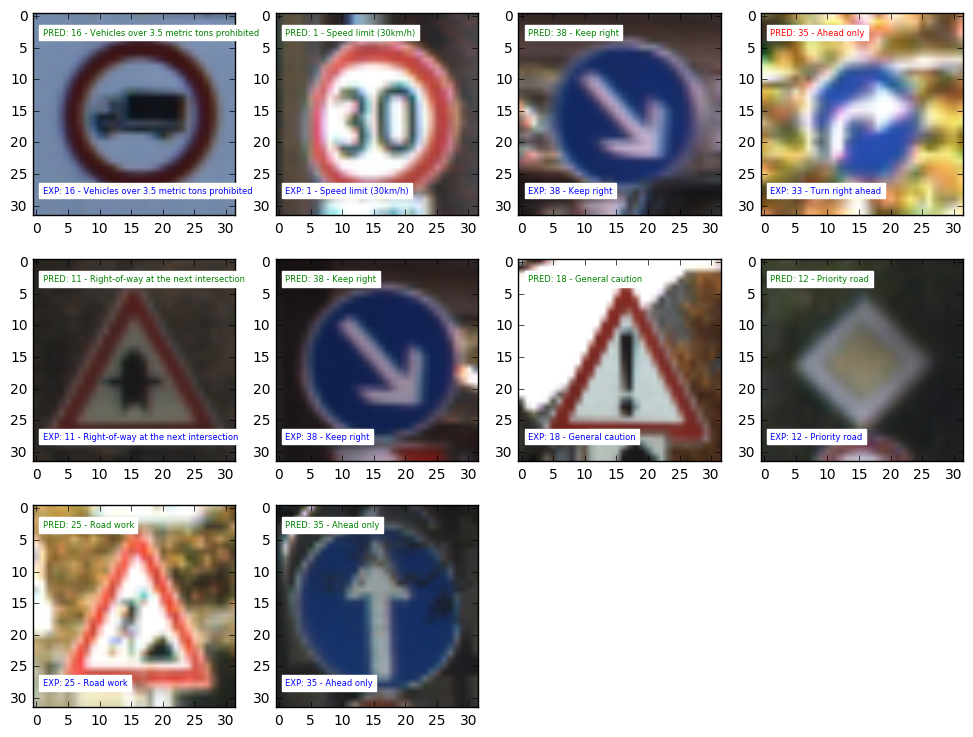

In [22]:
test_lower = 0
test_upper = 10
test_inputs = X_test[test_lower:test_upper]
expected_outputs = y_test[test_lower:test_upper]
predict_and_show(test_inputs, expected_outputs, model, lb, labels)